# Importing and Installing Dependencies

In [51]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import librosa
import numpy as np

# Building Data Loading Function

## Defining paths to files

In [2]:
CAPUCHIN_FILE = os.path.join('Dataset','Parsed_Capuchinbird_Clips','XC3776-0.wav')
NON_CAPUCHIN_FILE = os.path.join('Dataset','Parsed_Not_Capuchinbird_Clips','afternoon-birds-song-in-forest-0.wav')

## Building Data Loading Function

In [3]:
def load_wav_16k_mono(filename):
    wav, sample_rate=None,None
    if not isinstance(filename, str):
        filename = filename.numpy().decode('utf-8')
        wav, sample_rate = librosa.load(filename, sr=None, mono=True)
    else:
        wav, sample_rate = librosa.load(filename, sr=None, mono=True)
    
    # Resample the audio to 16000 Hz if the original sample rate is different
    if sample_rate != 16000:
        wav = librosa.resample(wav, orig_sr=sample_rate, target_sr=16000)
        sample_rate = 16000

    # Convert the numpy array to a TensorFlow tensor
    wav = tf.convert_to_tensor(wav, dtype=tf.float32)
    return wav

# Plot Wave

In [4]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NON_CAPUCHIN_FILE)

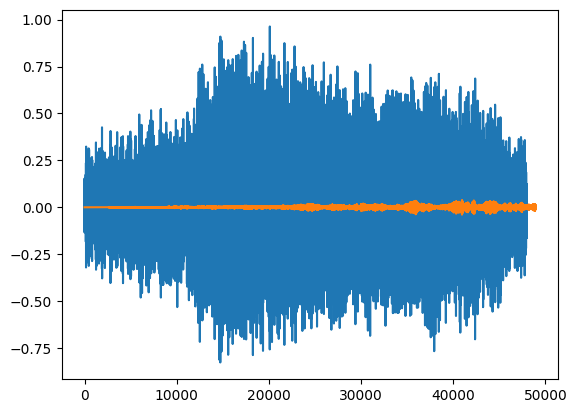

In [5]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

# Create Tensorflow Data

## Define Paths to Positive and Negative Data

In [6]:
POS = os.path.join('Dataset','Parsed_Capuchinbird_Clips')
NEG = os.path.join('Dataset','Parsed_Not_Capuchinbird_Clips')

## Create Tensorflow Datasets

In [7]:
pos = tf.data.Dataset.list_files(POS+'\*.wav')
neg = tf.data.Dataset.list_files(NEG+'\*.wav')

In [8]:
pos.as_numpy_iterator().next()

b'Dataset\\Parsed_Capuchinbird_Clips\\XC600460-4.wav'

## Add Labels and combine Positive and Negative Samples

In [9]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [10]:
data.as_numpy_iterator().next()

(b'Dataset\\Parsed_Capuchinbird_Clips\\XC227468-5.wav', 1.0)

# Detemine Average Length of a Capuchin Call

## Calculate Wave Cycle Length

In [11]:
lengths=[]
for file in os.listdir(os.path.join('Dataset','Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('Dataset','Parsed_Capuchinbird_Clips',file))
    lengths.append(len(tensor_wave))

## Calculate Mean, Min and Max

In [12]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

this means 54156 cycles per second
so it means every video has on an average (54156/16000) seconds length

In [13]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [14]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

# Building Preprocessing Function to Convert to Spectrogram

## Building Preprocessing Function

In [15]:
def preprocess(file_path,label):
    wav = tf.py_function(load_wav_16k_mono, [file_path], tf.float32)
    wav=wav[:48000]
    zero_padding=tf.zeros([48000]-tf.shape(wav),dtype=tf.float32)
    wav=tf.concat([zero_padding,wav],0)
    spectrogram=tf.signal.stft(wav,frame_length=320,frame_step=32) # short time fourier tranform
    '''
    frame_length: This parameter specifies the length of each analysis window or frame in samples. 
    In this case, it's set to 320 samples.
    
    frame_step: This parameter determines the number of samples to shift the analysis window 
    between consecutive frames. It controls the overlap between frames. Here, it's set to 32 
    samples, indicating a 90% overlap between adjacent frames (since 32/320 = 0.1).
    
    dimentions of the spectrogram are : (num_frames, num_frequency_bins)
    This dimension represents the number of frequency bins obtained from the Fourier transform within each frame.
    Each frequency bin corresponds to a specific frequency range or component of the signal's spectrum.
    '''
    spectrogram=tf.abs(spectrogram)
    spectrogram=tf.expand_dims(spectrogram,axis=2)
    return spectrogram,label


## Testing the Function and Viz the Spectrogram

In [16]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [17]:
spectrogram, label = preprocess(filepath, label)

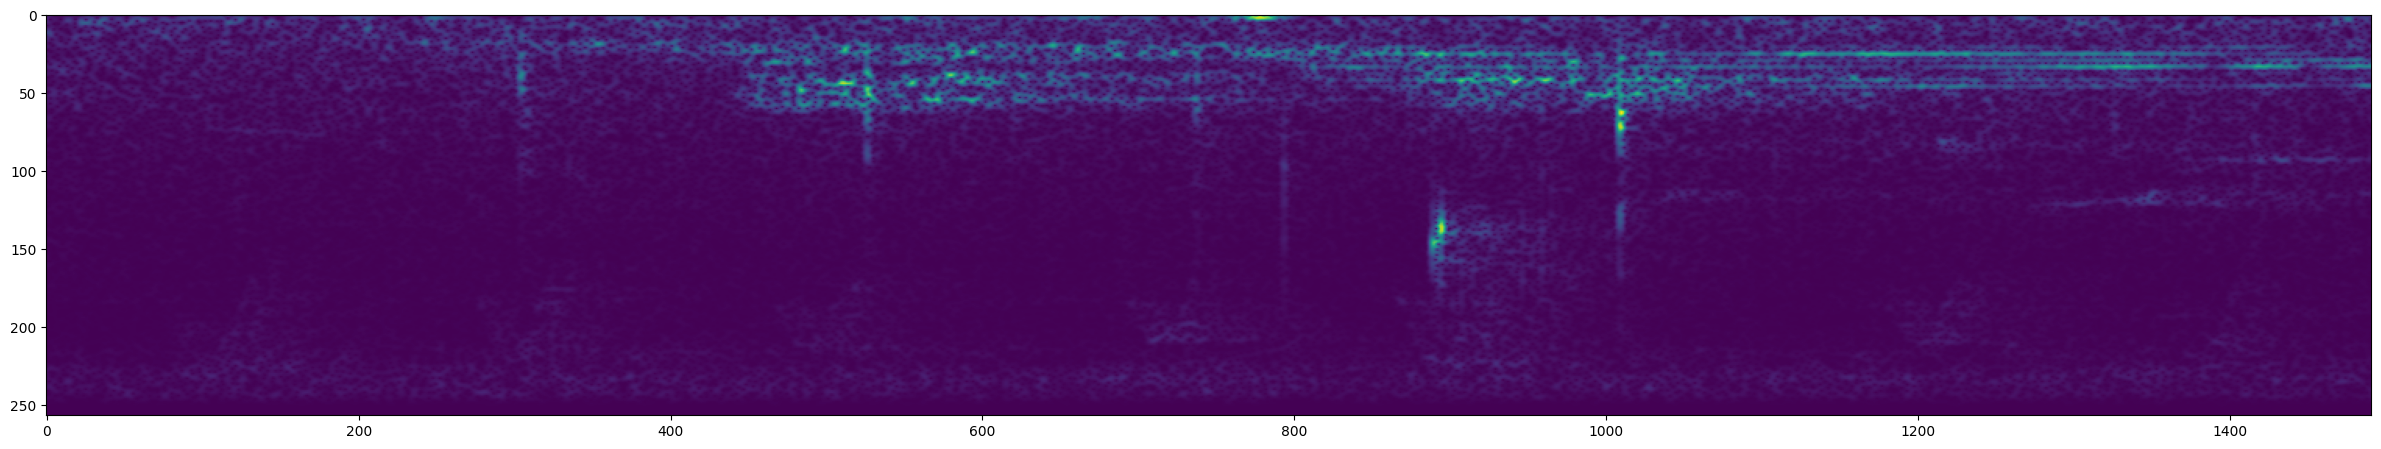

In [18]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# Creating Training and Testing Partitions

## Creating a Tensorflow data pipeline

In [19]:
data=data.map(preprocess)
data=data.cache()
data=data.shuffle(buffer_size=1000)
data=data.batch(16)
data=data.prefetch(8)

## Spliting in training and Testing Partisian

In [20]:
len(data)*.7

35.699999999999996

In [21]:
train=data.take(36)
test=data.skip(36).take(15)

## Testing one batch

In [22]:
samples,labels= train.as_numpy_iterator().next()

In [23]:
samples.shape

(16, 1491, 257, 1)

# Building Deep Learning Model

## Loading tensorflow Dependencies

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten

## Build Sequential Model, Compile and View Summary

In [25]:
tf.keras.backend.clear_session()

In [26]:
model=Sequential()
model.add(Conv2D(8,(3,3),activation='relu',input_shape=(1491,257,1)))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2))
model.add(Conv2D(8,(3,3),activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [27]:
model.compile('Adam',loss='BinaryCrossentropy',metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 8)      80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 744, 127, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 742, 125, 8)       584       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 371, 62, 8)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 184016)            0         
                                                                 
 dense (Dense)               (None, 64)                1

## Fit Model, View Loss and KPI Plots

In [30]:
hist=model.fit(train,epochs=5,validation_data=test)

Epoch 1/5
36/36 [==============================] - 15s 124ms/step - loss: 0.4352 - recall: 0.9013 - precision: 0.8354 - val_loss: 0.0644 - val_recall: 0.9315 - val_precision: 0.9855
Epoch 2/5
36/36 [==============================] - 4s 110ms/step - loss: 0.0618 - recall: 0.9756 - precision: 0.9756 - val_loss: 0.0648 - val_recall: 0.9841 - val_precision: 0.9841
Epoch 3/5
36/36 [==============================] - 4s 110ms/step - loss: 0.0687 - recall: 0.9809 - precision: 0.9935 - val_loss: 0.0046 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/5
36/36 [==============================] - 4s 111ms/step - loss: 0.0047 - recall: 0.9929 - precision: 1.0000 - val_loss: 0.0027 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 5/5
36/36 [==============================] - 4s 111ms/step - loss: 0.0048 - recall: 0.9937 - precision: 1.0000 - val_loss: 0.0074 - val_recall: 1.0000 - val_precision: 1.0000


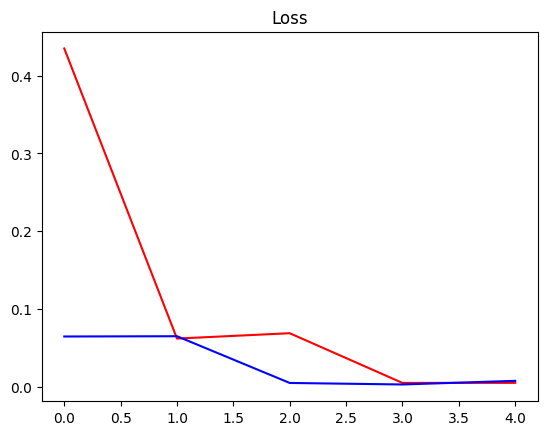

In [31]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

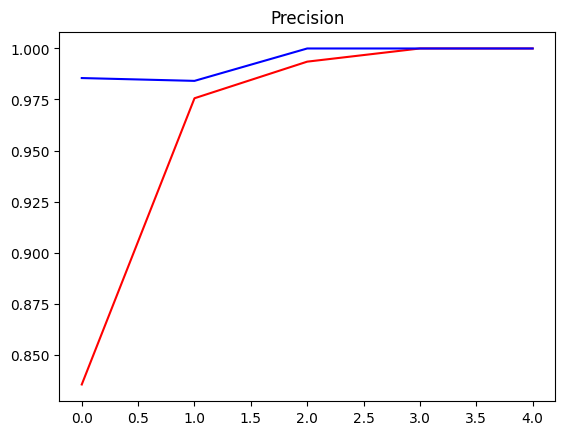

In [32]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

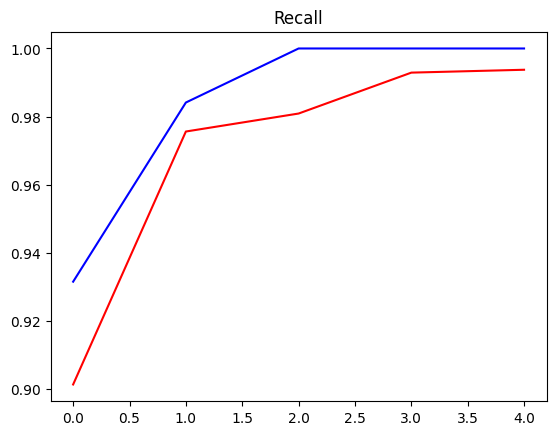

In [33]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

# Make a Prediction on a Single Clip

## Getting One Batch and Making a Prediction

In [34]:
X_test, y_test = test.as_numpy_iterator().next()

In [38]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 38ms/step


## Convert Logits to Classes

In [40]:
yhat = [ 1 if prediction > 0.5 else 0 for prediction in yhat ]

In [41]:
print(y_test,yhat)

[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


In [43]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=3>

In [44]:
tf.math.reduce_sum(y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=3.0>

## Saving the Model

In [42]:
model.save("audio_prediction.h5")

# Build Forest Parsing Functions

## Load up MP3

In [55]:
def load_mp3_16k_mono(filename):
    if not isinstance(filename, str):
        filename = filename.numpy().decode('utf-8')
    wav, sample_rate = librosa.load(filename, sr=None, mono=False)  # Load with all channels
    
    # Convert to numpy array if not already
    if not isinstance(wav, np.ndarray):
        wav = np.array(wav)

    # Calculate the average if there are multiple channels
    if wav.ndim > 1:
        wav = np.mean(wav, axis=0)
    
    # Resample the audio to 16000 Hz if the original sample rate is different
    if sample_rate != 16000:
        wav = librosa.resample(wav, orig_sr=sample_rate, target_sr=16000)
        sample_rate = 16000

    # Convert the numpy array to a TensorFlow tensor
    wav = tf.convert_to_tensor(wav, dtype=tf.float32)
    return wav


In [56]:
mp3 = os.path.join('Dataset', 'Forest Recordings', 'recording_00.mp3')

In [57]:
wav = load_mp3_16k_mono(mp3)

In [58]:
audio_slices=tf.keras.utils.timeseries_dataset_from_array(wav,wav,sequence_length=48000,sequence_stride=48000,batch_size=1)

In [59]:
samples,index=audio_slices.as_numpy_iterator().next()

In [61]:
print(len(audio_slices),samples.shape)

60 (1, 48000)


##  Building Function to Convert Clips into Windowed Spectrograms

In [64]:
def preprocess_mp3(sample,index):
    sample=sample[0] # reducing the dimention
    zero_padding=tf.zeros([48000]-tf.shape(sample),dtype=tf.float32)
    wav=tf.concat([zero_padding,sample],0)
    spectrogram=tf.signal.stft(wav,frame_length=320,frame_step=32) # short time fourier tranform
    spectrogram=tf.abs(spectrogram)
    spectrogram=tf.expand_dims(spectrogram,axis=2)
    return spectrogram


## Converting Loger Clips Into Windows and Make Predictions

In [70]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(16)

In [76]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.90 else 0 for prediction in yhat]

4/4 [==============================] - 1s 106ms/step


In [77]:
len(yhat)

60

## Grouping Consecutive Prediction

In [78]:
from itertools import groupby

In [79]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [80]:
calls

5

# Making Predictions

## Looping over all recordings and making predictions

In [82]:
results = {}
for file in os.listdir(os.path.join('Dataset', 'Forest Recordings')):
    FILEPATH = os.path.join('Dataset','Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(16)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

4/4 [==============================] - 1s 63ms/step


## Converting Predictions into Classes

In [85]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]

## Grouping Consecutive detections

In [87]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()

# Exporting Results

In [88]:
import csv

In [89]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])